In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook, trange
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.cluster import SpectralClustering

In [2]:
os.chdir(r"/raid6/roozbeh/trip_similarity/")

In [3]:
with pd.HDFStore("koln_by_hour_OD_and_scaled.h5") as store:
    OD8df = store["OD8df"]
    OD8df_scaled = store["OD8df_scaled"]
    OD12df = store["OD12df"]
    OD12df_scaled = store["OD12df_scaled"]
    OD16df = store["OD16df"]
    OD16df_scaled = store["OD16df_scaled"]
    OD20df = store["OD20df"]
    OD20df_scaled = store["OD20df_scaled"]

#### Matplotlib params

In [4]:
import matplotlib

In [5]:
matplotlib.rcParams.update({'font.size': 20,'xtick.labelsize':22,'ytick.labelsize':22})

##### Parameters Section

In [6]:
spatial_step = 50

time_threshold = 600 #seconds since data is per second

distance_sim_coef = 0.0001
time_sim_coef = 0.00015

##### Let's prepare the OD style of trips

In [7]:
OD8df.describe().loc[['min','max'],]

,time_begin,x_begin,y_begin,time_end,x_end,y_end
min,28800.0,3758.084711,1108.623441,28800.0,3916.012273,1105.472128
max,32399.0,25783.158495,31743.770000,32399.0,25775.636178,31918.184081


In [8]:
x_diff = max(OD8df.x_begin.max(),OD8df.x_end.max()) - min(OD8df.x_begin.min(), OD8df.x_end.min())
y_diff = max(OD8df.y_begin.max(),OD8df.y_end.max()) - min(OD8df.y_begin.min(), OD8df.y_end.min())
min_diff = min(x_diff,y_diff)
min_step = min_diff / spatial_step 
distance_threshold = min_step * np.sqrt(2)
distance_threshold

622.9631611561606

##### We get a sample of 10000 for ongoing rides + 2000 for the requests

In [9]:
reqDF = OD8df.sample(n=2000,random_state=1234)
ongoingDF = OD8df[~ OD8df.index.isin(reqDF.index)]

# ongoingDF = OD8df.sample(n=10000,random_state=1234)

# otherDF = OD8df[~ OD8df.index.isin(ongoingDF.index)]

# reqDF = otherDF.sample(n=2000,random_state=1234)

In [10]:
reqDF_scaled = OD8df_scaled.sample(n=2000,random_state=1234)
ongoingDF_scaled = OD8df_scaled[~ OD8df_scaled.index.isin(reqDF_scaled.index)]

###### Define Trip Similarity (1/(1+Dx))(1/(1+Dt))

In [9]:
# def get_trip_similarity_with_column_names(t1,t2):
#     sim = 0
#     sim += ( 1 / (1 + distance_sim_coef * np.linalg.norm((t1.x_begin-t2.x_begin,t1.y_begin-t2.y_begin),ord=2 ) ) )*\
#     ( 1 / (1 + time_sim_coef * np.absolute(t1.time_begin-t2.time_begin) ) )
#     sim += ( 1 / (1 + distance_sim_coef * np.linalg.norm((t1.x_end-t2.x_end,t1.y_end-t2.y_end),ord=2 ) ) )*\
#     ( 1 / (1 + time_sim_coef * np.absolute(t1.time_end-t2.time_end) ) )
#     return(sim)

##### IT IS NOT CORRECT (BELOW) t1 might have the trip_id ass the index so t1[0] is trip id!

In [10]:
def get_trip_similarity_from_tuple(t1,t2):
    sim = 0
    sim += ( 1 / (1 + distance_sim_coef * np.linalg.norm((t1[2]-t2[2],t1[3]-t2[3]),ord=2 ) ) )*\
    ( 1 / (1 + time_sim_coef * np.absolute(t1[1]-t2[1]) ) )
    sim += ( 1 / (1 + distance_sim_coef * np.linalg.norm((t1[6]-t2[6],t1[7]-t2[7]),ord=2 ) ) )*\
    ( 1 / (1 + time_sim_coef * np.absolute(t1[5]-t2[5]) ) )
    return(sim)

In [11]:
def get_trip_similarity_from_tuple_scaled(t1,t2,d_th,t_th):
    sim = 0
    sim += ( 1 - np.sqrt( (t1[2] - t2[1]) ** 2 + (t1[3] - t2[2])**2 )/d_th ) * ( 1 - np.absolute(t1[1]-t2[0])/t_th ) 
    sim += ( 1 - np.sqrt( (t1[6] - t2[5]) ** 2 + (t1[7] - t2[6])**2 )/d_th ) * ( 1 - np.absolute(t1[5]-t2[4])/t_th )
    return(sim)

In [12]:
def get_trip_sim_func(req):
    return lambda t : get_trip_similarity_from_tuple(req,t)

In [13]:
def get_trip_scaled_sim_func(req,d_th,t_th):
    return lambda t: get_trip_similarity_from_tuple_scaled(req,t,d_th,t_th)

## How many matches we get with change of distance for both OO and DD?

In [11]:
L_list = [1,5,10,20,40,80,160,320]

#### Let's see how many matches we get with a distance threshold for both origin and destination. 0.1 step, up to 5
Trips (req and ongoing) are within time threshold of one another

In [ ]:
match_counts_per_threshold = []
for i in tqdm_notebook(range(50)):
    thresh = i/10 * distance_threshold
    match_counts = []
    for trip_id,req in reqDF.iterrows():
        OO_distance = np.sqrt( (ongoingDF.x_begin - req.x_begin) ** 2 + (ongoingDF.y_begin - req.y_begin)**2 )
        DD_distance = np.sqrt( (ongoingDF.x_end - req.x_end) ** 2 + (ongoingDF.y_end - req.y_end)**2 )

        potential_matches = ongoingDF[(OO_distance <= thresh) & 
                                      (DD_distance <= thresh) &
                                      (abs(req.time_begin - ongoingDF.time_begin)<=time_threshold ) &
                                      (abs(req.time_end - ongoingDF.time_end)<=time_threshold )
                                     ]
        
        match_counts.append(len(potential_matches))
    
    match_counts_per_threshold.append((i,thresh,match_counts))

In [ ]:
for l in [1,5,10,20,40,80,160,320]:
    at_least_l_matches = [(i,j,len([t for t in k if t>=l])) for (i,j,k) in match_counts_per_threshold]
    idx,thresh,ncount = zip(*at_least_l_matches)
    plt.plot(thresh,ncount,label=l)

In [ ]:
fig = plt.gcf()
fig.set_size_inches((10,6))

plt.legend(loc=0,bbox_to_anchor=(1, 1.017),title="L-value")
plt.title("Number of at least L matches per threshold distance (in meters)" )
plt.show()

##### Let's zoom in on the first ~KM. testing with finer granularity (0.05 step, up to 1.25)

In [ ]:
match_counts_per_threshold = []
for i in tqdm_notebook(range(25)):
    thresh = i/20 * distance_threshold
    match_counts = []
    for req in reqDF.itertuples(name=None):
        OO_distance = np.sqrt( (ongoingDF.x_begin - req[2]) ** 2 + (ongoingDF.y_begin - req[3])**2 )
        DD_distance = np.sqrt( (ongoingDF.x_end - req[6]) ** 2 + (ongoingDF.y_end - req[7])**2 )

        potential_matches = ongoingDF[(OO_distance <= thresh) & 
                                      (DD_distance <= thresh) &
                                      (np.absolute(req.time_begin - ongoingDF.time_begin)<=time_threshold )
                                     ]
        
        match_counts.append(len(potential_matches))
    
    match_counts_per_threshold.append((i,thresh,match_counts))

In [ ]:
for l in [0,10,20,40,80,160,320]:
    at_least_l_matches = [(i,j,len([t for t in k if t>l])) for (i,j,k) in match_counts_per_threshold]
    idx,thresh,ncount = zip(*at_least_l_matches)
    plt.plot(thresh,ncount,label=l)

In [ ]:
fig = plt.gcf()
fig.set_size_inches((10,6))
plt.legend(loc=0,bbox_to_anchor=(1, 1.017),title="L-value")
plt.title("Number of at least L matches per distance threshold (in meters)" )
plt.show()

#### What if we consider a scenario in which people can <font color=red>walk</font> to the start point and walk to destination after getting off.

In [12]:
time_threshold = 900 #sec

In [13]:
ongoingDF_scaled.describe()

,time_begin,x_begin,y_begin,time_end,x_end,y_end
count,40070.000000,40070.000000,40070.000000,40070.000000,40070.000000,4.007000e+04
mean,0.388139,0.509107,0.450692,0.513022,0.481140,4.418759e-01
std,0.332787,0.211713,0.156934,0.324283,0.187545,1.350251e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.433426e-07
25%,0.039733,0.356913,0.356950,0.220339,0.373452,3.693107e-01
50%,0.343707,0.489301,0.436715,0.488191,0.454240,4.289423e-01
75%,0.687691,0.667437,0.531283,0.821617,0.604347,5.053595e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00


In [14]:
match_counts_per_threshold_walk = []

for i in tqdm_notebook(range(8)):
    thresh = i/2 * distance_threshold
    match_counts = []
    for req in reqDF.itertuples():
        potential_matches = ongoingDF
        
        OO_time_mask = (req.time_begin <= potential_matches.time_begin) & ((potential_matches.time_begin - req.time_begin)<=time_threshold) 
        
        potential_matches = potential_matches[OO_time_mask]
        
        DD_time_mask = ((req.time_end >= potential_matches.time_end) & (( req.time_end - potential_matches.time_end)<=time_threshold))
                                    
        potential_matches = potential_matches[DD_time_mask]
        
        
        OO_distance = np.sqrt( (potential_matches.x_begin - req.x_begin) ** 2 + (potential_matches.y_begin - req.y_begin)**2 )
        
        potential_matches = potential_matches[(OO_distance <= thresh)] 
        
        DD_distance = np.sqrt( (potential_matches.x_end - req.x_end) ** 2 + (potential_matches.y_end - req.y_end)**2 )

        potential_matches = potential_matches[(DD_distance <= thresh)]

        
        
        match_counts.append(len(potential_matches))
    
    match_counts_per_threshold_walk.append((i,thresh,match_counts))

In [15]:
import itertools

In [16]:
markers = itertools.cycle(('x', 'o', '*', '+','s','p','d', '.'))

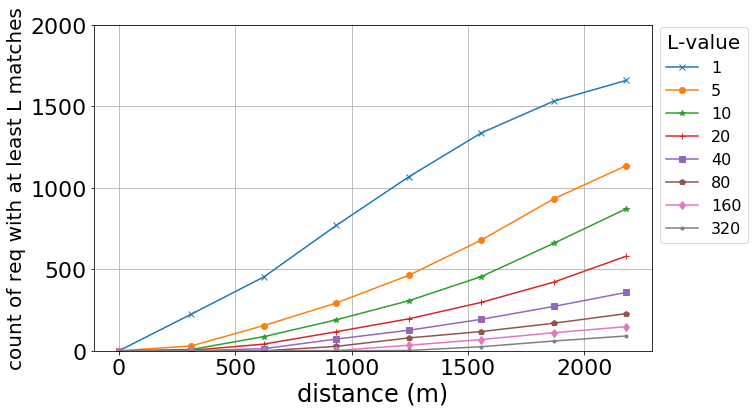

In [17]:
fig = plt.figure(figsize=(10,6))
 
for l in L_list:
    at_least_l_matches = [(i,j,len([t for t in k if t>=l])) for (i,j,k) in match_counts_per_threshold_walk]
    idx,thresh,ncount = zip(*at_least_l_matches)
    plt.plot(thresh,ncount,label=l,marker=next(markers),markevery=1)

plt.gca().set_ylim((0,2000))
plt.gca().set_xlabel("distance (m)",size=24)
plt.gca().set_ylabel("count of req with at least L matches",size=20)
plt.legend(loc=0,bbox_to_anchor=(1, 1.017),title="L-value",fontsize=16)
# plt.title("Number of at least L matches per distance threshold (in meters) - Walking" )
plt.grid()
plt.show()

#### Let's change time threshold as well and see what happens

In [20]:
match_counts_per_threshold_walk_timed = []
distance_threshold = 1800
for t in tqdm_notebook([60,300,600,900,1200,1500,1800]):
    match_counts = []
    for trip_id,req in reqDF.iterrows():
        OO_distance = np.sqrt( (ongoingDF.x_begin - req.x_begin) ** 2 + (ongoingDF.y_begin - req.y_begin)**2 )
        DD_distance = np.sqrt( (ongoingDF.x_end - req.x_end) ** 2 + (ongoingDF.y_end - req.y_end)**2 )

        potential_matches = ongoingDF[(OO_distance <= distance_threshold) & 
                                      (DD_distance <= distance_threshold) &
                                      ((req.time_begin <= ongoingDF.time_begin) & ((ongoingDF.time_begin - req.time_begin)<= t ) ) &
                                      ((req.time_end >= ongoingDF.time_end) & (( req.time_end - ongoingDF.time_end)<= t ))
                                     ]
        
        match_counts.append(len(potential_matches))
    
    match_counts_per_threshold_walk_timed.append((t,match_counts))

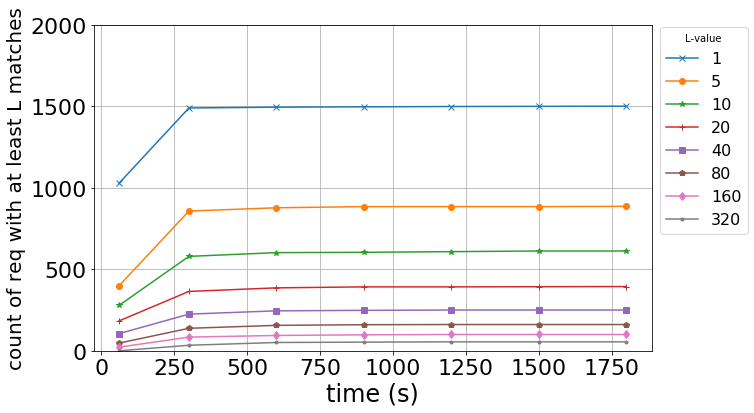

In [44]:
%matplotlib inline
for l in [1,5,10,20,40,80,160,320]:
    at_least_l_matches = [(i,len([t for t in k if t>=l])) for (i,k) in match_counts_per_threshold_walk_timed]
    thresh,ncount = zip(*at_least_l_matches)
    plt.plot(thresh,ncount,label=l,marker=next(markers))
fig = plt.gcf()
fig.set_size_inches((10,6))
plt.gca().set_ylim((0,2000))

plt.legend(loc=0,bbox_to_anchor=(1, 1.017),title="L-value",fontsize=16)
plt.gca().set_xlabel("time (s)",size=24)
plt.gca().set_ylabel("count of req with at least L matches",size=20)
# plt.title("Number of more than L matches per time threshold (in second)" )
plt.grid()
plt.show()

In [19]:
match_counts_per_time_per_dist = []
for t_th in tqdm_notebook([60,300,600,900,1200,1500,1800]):    
    for d_th in [0.2*i*distance_threshold for i in range(0,20)]:
        
        for trip_id,req in reqDF.iterrows():
            
            OO_distance = np.sqrt( (ongoingDF.x_begin - req.x_begin) ** 2 + (ongoingDF.y_begin - req.y_begin)**2 )
            DD_distance = np.sqrt( (ongoingDF.x_end - req.x_end) ** 2 + (ongoingDF.y_end - req.y_end)**2 )

            potential_matches = ongoingDF[(OO_distance <= d_th) & 
                                          (DD_distance <= d_th) &
                                          ((req.time_begin <= ongoingDF.time_begin) & ((ongoingDF.time_begin - req.time_begin)<= t_th ) ) &
                                          ((req.time_end >= ongoingDF.time_end) & (( req.time_end - ongoingDF.time_end)<= t_th ))
                                         ]

            match_counts_per_time_per_dist.append((t_th,d_th,len(potential_matches)))    

KeyboardInterrupt: 

In [46]:
match_counts_walk_per_time_per_dist_df = pd.DataFrame(match_counts_per_time_per_dist,columns=["time_threshold","distance_threshold","match_counts"])

In [47]:
match_counts_walk_per_time_per_dist_df[2000:2002]

,time_threshold,distance_threshold,match_counts


In [45]:
match_counts_walk_per_time_per_dist_df.to_parquet("match_counts_walk_per_time_per_dist_df")

Uncomment below to save results to hdfs

In [52]:
# store.open()
# store["match_counts_walking_per_time_and_dist_thresh_df"] = match_counts_walk_per_time_per_dist_df
# store.close()

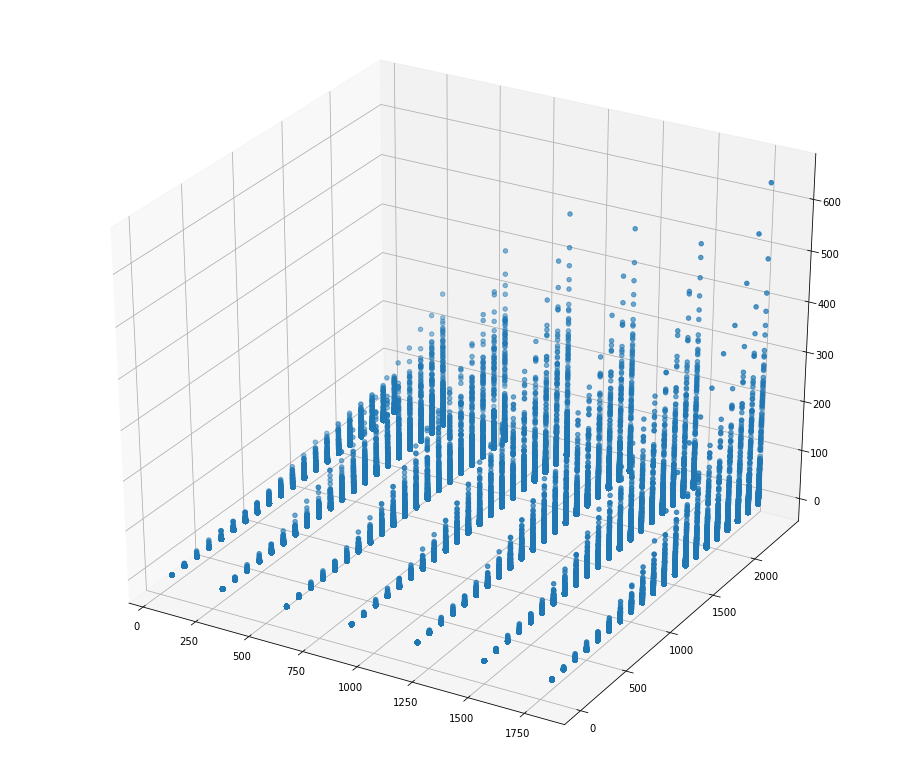

In [46]:
fig = plt.figure(figsize=(16,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(match_counts_walk_per_time_per_dist_df["time_threshold"],
           match_counts_walk_per_time_per_dist_df["distance_threshold"],
           match_counts_walk_per_time_per_dist_df["match_counts"])
plt.show()

In [48]:
temp = match_counts_walk_per_time_per_dist_df.groupby(["time_threshold","distance_threshold"])\
        .apply(lambda x: [len(x[x.match_counts >= l]) for l in L_list])\
        .reset_index(name="l_counts")

In [51]:
l_df = pd.DataFrame( temp.l_counts.values.tolist(),columns=list(map(lambda x: "l_"+str(x),L_list)  ) )
l_df = pd.concat([temp.drop("l_counts",axis=1),l_df],axis=1)

In [52]:
l_df.iloc[:3]

,time_threshold,distance_threshold,l_1,l_5,l_10,l_20,l_40,l_80,l_160,l_320
0,60,0.000000,0,0,0,0,0,0,0,0
1,60,124.592632,29,3,0,0,0,0,0,0
2,60,249.185264,43,4,1,0,0,0,0,0


In [ ]:
fig = plt.figure(figsize=(12,30))
time_groups = l_df.groupby("time_threshold")
group_len = len(time_groups)
for idx,(t_th, t_group) in enumerate(time_groups,start=1):
    ax = fig.add_subplot(group_len,1,idx)
    ax.set_ylim((0,2000))
    ax.set_ylabel("count of requests with at least L matches")
    ax.set_xlabel("distance threshold (meters)")
    for col_i,_col in enumerate(t_group.columns[2:]):
        ax.plot(t_group.distance_threshold,
                t_group[_col],
                label=L_list[col_i],marker="x")
        
    ax.set_title("time threshold="+str(t_th))
fig.legend(title="L-value",loc='upper center', ncol=9, bbox_to_anchor=(0.5,1.02))
plt.tight_layout()
plt.show()

In [225]:
fig = plt.figure(figsize=(12,60))
d_groups = l_df.groupby("distance_threshold")
group_len = len(d_groups)
for idx,(d_th, d_group) in enumerate(d_groups,start=1):
    ax = fig.add_subplot(group_len,1,idx)
    ax.set_ylim((0,2000))
    ax.set_ylabel("count of requests with at least L matches")
    ax.set_xlabel("time threshold (seconds)")
    for col_i,_col in enumerate(d_group.columns[2:]):
        ax.plot(d_group.time_threshold,
                d_group[_col],
                label=l_list[col_i],marker="x")
        
    ax.set_title("distance threshold="+str(d_th))
        

In [ ]:
fig.legend(title="L-value",loc='upper center', ncol=9, bbox_to_anchor=(0.5,1.01))
plt.tight_layout()
plt.show()

In [518]:
w_x = 0.6
w_t = 0.4

t_th = 900 #seconds
d_th = 1800 #meters

#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
# t1 is rider (walker) and t2 is the ride
def get_trip_similarity_from_tuple_WALK2_wgm(t1,t2):
    oo_dist = np.sqrt( (t1[1] - t2[1]) ** 2 + (t1[2] - t2[2])**2 )

    oo_t = (t2[0] - t1[0]) #t2 should start after t1
    oo_t = 10000 if oo_t < 0 else oo_t
    
    sim = np.exp(w_x * np.log(1./(1+oo_dist/d_th)) + w_t * np.log(1./(1+ oo_t/t_th)) ) 
       
    dd_dist = np.sqrt( (t1[4] - t2[4]) ** 2 + (t1[5] - t2[5])**2 )
    
    dd_t = (t1[3] - t2[3]) # t2 should finish before t1 so that t1 can walk to its dest
    dd_t = 10000 if dd_t < 0 else dd_t

    sim += np.exp(w_x * np.log(1./(1+dd_dist/d_th) + w_t * np.log(1./(1+ dd_t/t_th)) ) )
    
    return(sim/2)

In [519]:
results = []
ongoing_counts = dict()

In [520]:
for req in tqdm_notebook(reqDF.itertuples(index=False),total=2000):
    
    potential_matches = ongoingDF

    OO_time_mask = (req.time_begin <= potential_matches.time_begin) & ((potential_matches.time_begin - req.time_begin)<=t_th) 

    potential_matches = potential_matches[OO_time_mask]

    DD_time_mask = ((req.time_end >= potential_matches.time_end) & (( req.time_end - potential_matches.time_end)<=t_th))

    potential_matches = potential_matches[DD_time_mask]


    OO_distance = np.sqrt( (potential_matches.x_begin - req.x_begin) ** 2 + (potential_matches.y_begin - req.y_begin)**2 )

    potential_matches = potential_matches[(OO_distance <= d_th)] 

    DD_distance = np.sqrt( (potential_matches.x_end - req.x_end) ** 2 + (potential_matches.y_end - req.y_end)**2 )

    potential_matches = potential_matches[(DD_distance <= d_th)]


    if potential_matches.empty:
        results.append((req,None))
    else:
        potential_matches["similarity"] = potential_matches.apply(lambda t : get_trip_similarity_from_tuple_WALK2_wgm(req,t),axis=1)

        top_matches = potential_matches.sort_values(by="similarity",ascending=False)
                
        results.append( (req, top_matches[:5]) )
        
        if top_matches.index.values[0] in ongoing_counts:
            ongoing_counts[top_matches.index.values[0]]+=1
        else:
            ongoing_counts[top_matches.index.values[0]]=1




A Jupyter Widget

In [521]:
from collections import Counter

In [522]:
 c,v = zip(*Counter(ongoing_counts.values()).items())

In [523]:
plt.bar(c,v,width=0.5)

<Container object of 4 artists>

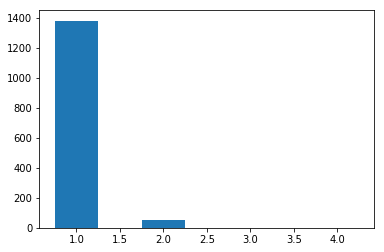

In [524]:
plt.show()

In [525]:
results[:2]

[(Pandas(time_begin=29947, x_begin=11801.55, y_begin=20658.49, time_end=30304, x_end=10247.316951012675, y_end=18694.25012093886),
           time_begin   x_begin   y_begin  time_end        x_end         y_end  \
  trip_id                                                                        
  314119        30064  12765.96  20747.31     30228  11324.73296  20082.597459   
  
           similarity  
  trip_id              
  314119     0.687052  ),
 (Pandas(time_begin=31633, x_begin=17177.04, y_begin=3300.27, time_end=32351, x_end=23973.969132473867, y_end=3117.020023722951),
  None)]

Most of matched ongoing rides have 1 match to them!

-----

#### Saved miles based on Euclidean distance.


In [526]:
match_count = 0
match_kms = []
req_with_match_kms = []
req_kms = []
oo_kms = []
dd_kms = []
oo_times = []
dd_times= []
for req, matches in tqdm_notebook(results):
    req_kms.append(np.sqrt((req.x_begin - req.x_end) ** 2 + (req.y_begin - req.y_end) ** 2 ))
    if(matches is not None):
        match = matches.iloc[0]
        match_count+=1
        req_with_match_kms.append(np.sqrt((req.x_begin - req.x_end) ** 2 + (req.y_begin - req.y_end) ** 2 ))
        match_kms.append(np.sqrt((match.x_begin - match.x_end) ** 2 + (match.y_begin - match.y_end) ** 2 ))
        oo_kms.append(np.sqrt((match.x_begin - req.x_begin) ** 2 + (match.y_begin - req.y_begin) ** 2 ))
        dd_kms.append(np.sqrt((match.x_end - req.x_end) ** 2 + (match.y_end - req.y_end) ** 2 ))
        oo_times.append(match.time_begin - req.time_begin)
        dd_times.append(req.time_end - match.time_end)
        
    

A Jupyter Widget

In [527]:
print("matching with time_threshold of {} and distance_threshold of {}".format(t_th,d_th) )

print("number of req with at least a match:",match_count)

print("match travels (km): ",np.sum(match_kms)/1000)

print("req travels (km): ",np.sum(req_kms)/1000)

print("req travels when they have at least one match (km):",np.sum(req_with_match_kms)/1000)

print("match/match+req ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_kms)))

print("match/match+req with at least 1 match ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_with_match_kms)))

print("origin-origin distance (km): ",np.sum(oo_kms)/1000)

print("dest-dest distance (km): ",np.sum(dd_kms)/1000)

print("origin-origin times (sec): ",np.sum(oo_times))

print("dest-dest times (sec): ",np.sum(dd_times))

matching with time_threshold of 900 and distance_threshold of 1800
number of req with at least a match: 1496
match travels (km):  4356.36832284
req travels (km):  8633.83105683
req travels when they have at least one match (km): 5235.31938089
match/match+req ratio:  0.335358080004
match/match+req with at least 1 match ratio:  0.454181626571
origin-origin distance (km):  1017.66554166
dest-dest distance (km):  1045.91220045
origin-origin times (sec):  70185.0
dest-dest times (sec):  88873.0


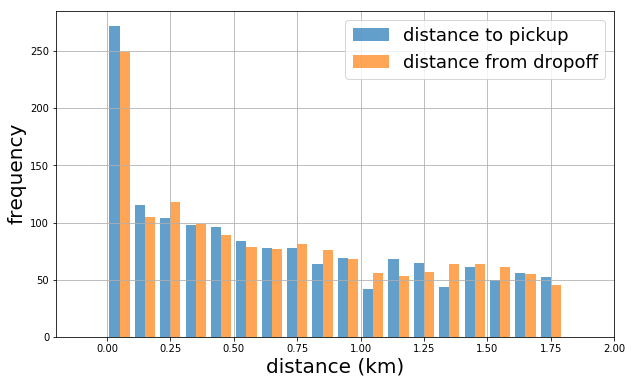

In [528]:
plt.figure(figsize=(10,6))
plt.hist([np.array(oo_kms)/1000,np.array(dd_kms)/1000],alpha=0.7,bins=[i*0.1 for i in range(30)],label=["distance to pickup","distance from dropoff"])
ax = plt.gca()
ax.set_xlim((-.2,2))
ax.set_xlabel("distance (km)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
plt.grid()
plt.legend(prop={'size': 18})
plt.show()

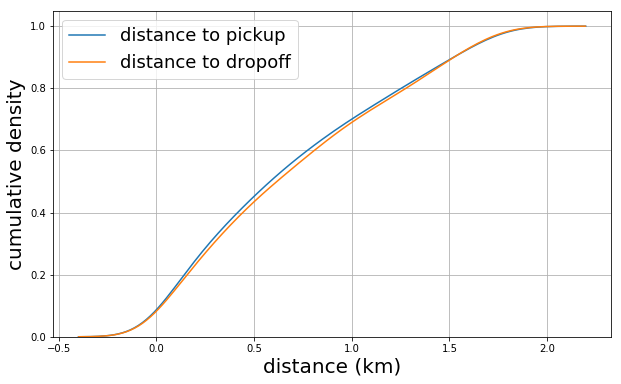

In [529]:
plt.figure(figsize=(10,6))
# plt.gca().set_xlim((-1.5,20))
ax = sns.distplot(np.array(oo_kms)/1000,bins=22,hist=False,kde_kws={'cumulative':True},label="distance to pickup")
sns.distplot(np.array(dd_kms)/1000,bins=22,hist=False,kde_kws={'cumulative':True}, label="distance to dropoff")
ax.set_xlabel("distance (km)",fontsize=20)
ax.set_ylabel("cumulative density",fontsize=20)
plt.grid()
plt.legend(prop = {'size' : 18})
plt.show()

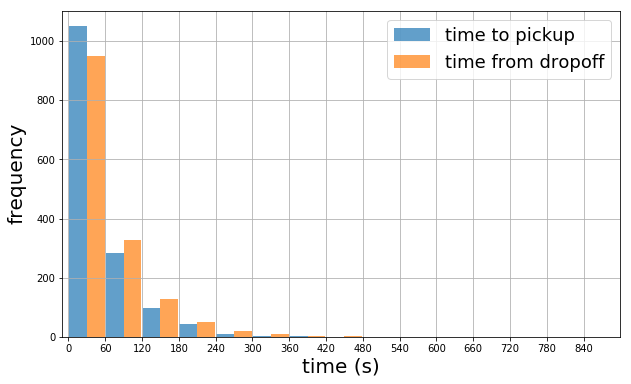

In [530]:
plt.figure(figsize=(10,6))
plt.hist([np.array(oo_times),np.array(dd_times)],alpha=0.7,bins=[i*60 for i in range(10)],label=["time to pickup","time from dropoff"],align='mid',rwidth=0.97)
ax = plt.gca()
ax.set_xlim((-10,900))
plt.xticks(np.arange(0, 900, 60))
ax.set_xlabel("time (s)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
plt.grid()
plt.legend(prop={'size': 18})
plt.show()

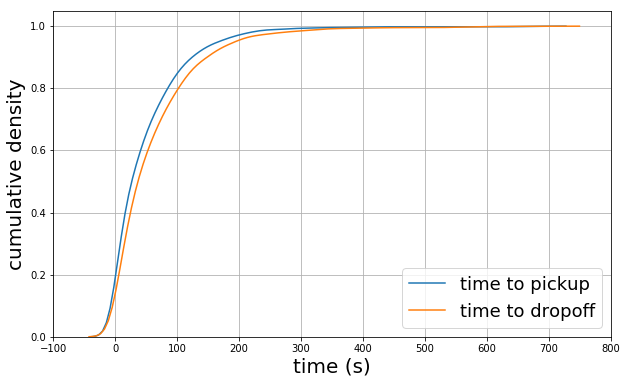

In [531]:
plt.figure(figsize=(10,6))
ax = sns.distplot(np.array(oo_times),hist=False,kde_kws={'cumulative':True},label="time to pickup")
sns.distplot(np.array(dd_times),hist=False,kde_kws={'cumulative':True}, label="time to dropoff")
ax.set_xlabel("time (s)",fontsize=20)
ax.set_ylabel("cumulative density",fontsize=20)
ax.set_xlim((-100,800))
plt.grid()
plt.legend(prop = {'size' : 18})
plt.show()

----


### THIS IS CARPOOLING!!!

In [513]:
reqDF = OD8df.sample(n=2000,random_state=1234)
ongoingDF = OD8df[~ OD8df.index.isin(reqDF.index)]

# ongoingDF = OD8df.sample(n=10000,random_state=1234)

# otherDF = OD8df[~ OD8df.index.isin(ongoingDF.index)]

# reqDF = otherDF.sample(n=2000,random_state=1234)

In [500]:
reqDF_scaled = OD8df_scaled.sample(n=2000,random_state=1234)
ongoingDF_scaled = OD8df_scaled[~ OD8df_scaled.index.isin(reqDF_scaled.index)]

In [501]:
w_x = 0.6
w_t = 0.4
d_th = 1800
t_th = 900
#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
# t1 is rider and t2 is the ride
def get_trip_similarity_from_tuple_CARPOOL_wgm(t1,t2):
    oo_dist = np.sqrt( (t1[1] - t2[1]) ** 2 + (t1[2] - t2[2])**2 )
    oo_t = (t1[0] - t2[0]) #t2 should start before t1
#     oo_t = oo_t + 5000 if oo_t < 0 else oo_t

    sim = np.exp(w_x * np.log(1./(1+oo_dist/d_th)) + w_t * np.log(1./(1+oo_t/t_th)) )
    
    dd_dist = np.sqrt( (t1[4] - t2[4]) ** 2 + (t1[5] - t2[5])**2 )
    dd_t = (t2[3] - t1[3]) # t2 should finish after t1 so that t2 can go its destination finally
#     dd_t = dd_t + 5000 if dd_t < 0 else dd_t
    
    sim += np.exp(w_x * np.log(1./(1+dd_dist/d_th)) + w_t * np.log(1./(1+dd_t/t_th)) )
    
    return(sim/2)

In [534]:
results_cp = []
ongoing_counts_cp = dict()

In [535]:
for req in tqdm_notebook(reqDF.itertuples(index=False),total=2000):
    
    potential_matches = ongoingDF

    OO_time_mask = (potential_matches.time_begin  <= req.time_begin) & (( req.time_begin - potential_matches.time_begin)<=t_th) 

    potential_matches = potential_matches[OO_time_mask]

    DD_time_mask = ((req.time_end <= potential_matches.time_end) & (( potential_matches.time_end - req.time_end )<=t_th))

    potential_matches = potential_matches[DD_time_mask]


    OO_distance = np.sqrt( (potential_matches.x_begin - req.x_begin) ** 2 + (potential_matches.y_begin - req.y_begin)**2 )

    potential_matches = potential_matches[(OO_distance <= d_th)] 

    DD_distance = np.sqrt( (potential_matches.x_end - req.x_end) ** 2 + (potential_matches.y_end - req.y_end)**2 )

    potential_matches = potential_matches[(DD_distance <= d_th)]


    if potential_matches.empty:
        results_cp.append((req,None))
    else:
        potential_matches["similarity"] = potential_matches.apply(lambda t : get_trip_similarity_from_tuple_CARPOOL_wgm(req,t),axis=1)

        top_matches = potential_matches.sort_values(by="similarity",ascending=False)
                
        results_cp.append( (req, top_matches[:5]) )
        
        if top_matches.index.values[0] in ongoing_counts_cp:
            ongoing_counts_cp[top_matches.index.values[0]]+=1
        else:
            ongoing_counts_cp[top_matches.index.values[0]]=1




A Jupyter Widget

In [536]:
from collections import Counter

In [542]:
 c,v = zip(*Counter(ongoing_counts_cp.values()).items())

In [543]:
plt.bar(c,v,width=0.5)

<Container object of 3 artists>

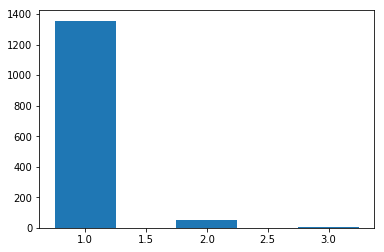

In [544]:
plt.show()

Most of matched ongoing rides have 1 match to them!

In [540]:
# results_500s = results

In [541]:
# results_nocutoff = results

-----

In [552]:
match_count = 0
match_kms = []
req_with_match_kms = []
req_kms = []
sim_scores = []
oo_kms = []
dd_kms = []
oo_times = []
dd_times= []
for req, matches in tqdm_notebook(results_cp):
    req_kms.append(np.sqrt((req.x_begin - req.x_end) ** 2 + (req.y_begin - req.y_end) ** 2 ))
    if(matches is not None):
        match = matches.iloc[0]
        match_count+=1
        sim_scores.append(match.similarity)
        req_with_match_kms.append(np.sqrt((req.x_begin - req.x_end) ** 2 + (req.y_begin - req.y_end) ** 2 ))
        match_kms.append(np.sqrt((match.x_begin - match.x_end) ** 2 + (match.y_begin - match.y_end) ** 2 ))
        oo_kms.append(np.sqrt((match.x_begin - req.x_begin) ** 2 + (match.y_begin - req.y_begin) ** 2 ))
        dd_kms.append(np.sqrt((match.x_end - req.x_end) ** 2 + (match.y_end - req.y_end) ** 2 ))
        oo_times.append(req.time_begin - match.time_begin)
        dd_times.append(match.time_end - req.time_end)
        
    

A Jupyter Widget

In [553]:
print("matching with time_threshold of {} and distance_threshold of {}".format(t_th,d_th) )

print("number of req with at least a match:",match_count)

print("match travels (km): ",np.sum(match_kms)/1000)

print("req travels (km): ",np.sum(req_kms)/1000)

print("req travels when they have at least one match (km):",np.sum(req_with_match_kms)/1000)

print("match/match+req ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_kms)))

print("match/match+req with at least 1 match ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_with_match_kms)))

print("origin-origin distance (km): ",np.sum(oo_kms)/1000)

print("dest-dest distance (km): ",np.sum(dd_kms)/1000)

print("origin-origin times (sec): ",np.sum(oo_times))

print("dest-dest times (sec): ",np.sum(dd_times))

matching with time_threshold of 900 and distance_threshold of 1800
number of req with at least a match: 1458
match travels (km):  5486.78511916
req travels (km):  8633.83105683
req travels when they have at least one match (km): 4938.07384979
match/match+req ratio:  0.388565559093
match/match+req with at least 1 match ratio:  0.526317443286
origin-origin distance (km):  948.43833131
dest-dest distance (km):  1019.56045152
origin-origin times (sec):  83171.0
dest-dest times (sec):  88064.0


We don't have many potential matches that's why it doesn't change much with the choice!

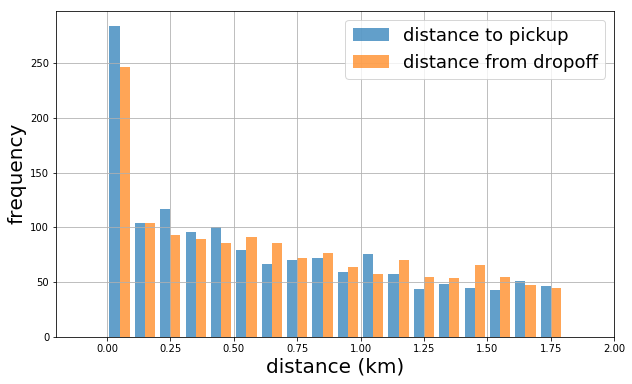

In [554]:
plt.figure(figsize=(10,6))
plt.hist([np.array(oo_kms)/1000,np.array(dd_kms)/1000],alpha=0.7,bins=[i*0.1 for i in range(30)],label=["distance to pickup","distance from dropoff"])
ax = plt.gca()
ax.set_xlim((-.2,2))
ax.set_xlabel("distance (km)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
plt.grid()
plt.legend(prop={'size': 18})
plt.show()

In [1]:
plt.figure(figsize=(10,6))
# plt.gca().set_xlim((-1.5,20))
ax = sns.distplot(np.array(oo_kms)/1000,bins=22,hist=False,kde_kws={'cumulative':True},label="distance to pickup")
sns.distplot(np.array(dd_kms)/1000,bins=22,hist=False,kde_kws={'cumulative':True}, label="distance to dropoff")
ax.set_xlabel("distance (km)",fontsize=24)
ax.set_ylabel("cumulative density",fontsize=24)
plt.grid()
plt.legend(prop = {'size' : 18})
plt.show()

NameError: name 'plt' is not defined

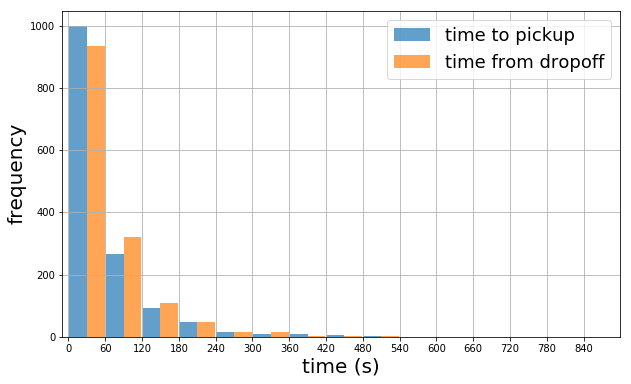

In [565]:
plt.figure(figsize=(10,6))
plt.hist([np.array(oo_times),np.array(dd_times)],alpha=0.7,bins=[i*60 for i in range(10)],label=["time to pickup","time from dropoff"],align='mid',rwidth=0.97)
ax = plt.gca()
ax.set_xlim((-10,900))
plt.xticks(np.arange(0, 900, 60))
ax.set_xlabel("time (s)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
plt.grid()
plt.legend(prop={'size': 18})
plt.show()

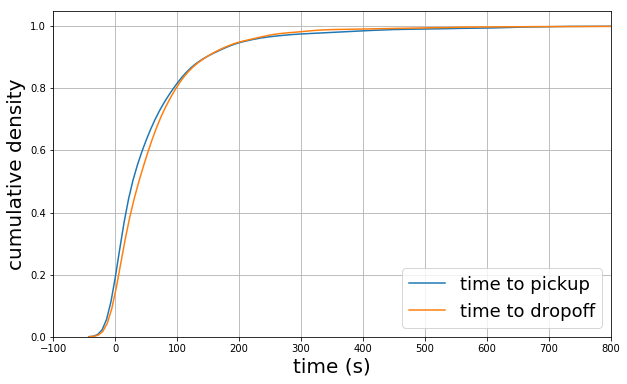

In [562]:
plt.figure(figsize=(10,6))
ax = sns.distplot(np.array( oo_times),hist=False,kde_kws={'cumulative':True},label="time to pickup")
sns.distplot(np.array( dd_times),hist=False,kde_kws={'cumulative':True}, label="time to dropoff")
ax.set_xlabel("time (s)",fontsize=20)
ax.set_ylabel("cumulative density",fontsize=20)
ax.set_xlim((-100,800))
plt.grid()
plt.legend(prop = {'size' : 18})
plt.show()

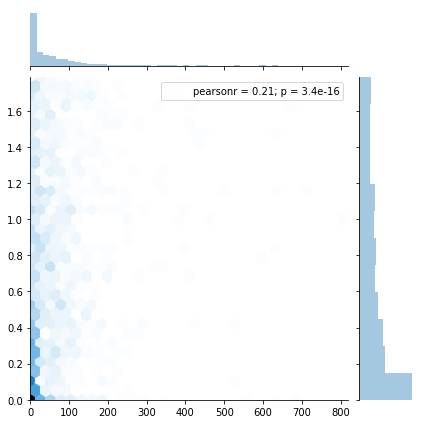

In [566]:
plt.figure(figsize=(10,6))
sns.jointplot(x=np.array(oo_times),y=np.array(oo_kms)/1000,kind="hex")
plt.show()

In [573]:
match_counts_per_threshold_cp = []
t_th = 900
distance_threshold = 660 #based on map info (see top of this notebook!)
for i in tqdm_notebook(range(8)):
    thresh = i/2 * distance_threshold
    match_counts = []
    for req in reqDF.itertuples():
        potential_matches = ongoingDF
        
        OO_time_mask = ( (potential_matches.time_begin  <= req.time_begin) & (( req.time_begin - potential_matches.time_begin)<=t_th) )

        potential_matches = potential_matches[OO_time_mask]

        DD_time_mask = ( (req.time_end <= potential_matches.time_end) & (( potential_matches.time_end - req.time_end )<=t_th) )

        potential_matches = potential_matches[DD_time_mask]
        
        
        OO_distance = np.sqrt( (potential_matches.x_begin - req.x_begin) ** 2 + (potential_matches.y_begin - req.y_begin)**2 )
        
        potential_matches = potential_matches[(OO_distance <= thresh)] 
        
        DD_distance = np.sqrt( (potential_matches.x_end - req.x_end) ** 2 + (potential_matches.y_end - req.y_end)**2 )

        potential_matches = potential_matches[(DD_distance <= thresh)]

        
        
        match_counts.append(len(potential_matches))
    
    match_counts_per_threshold_cp.append((i,thresh,match_counts))

A Jupyter Widget

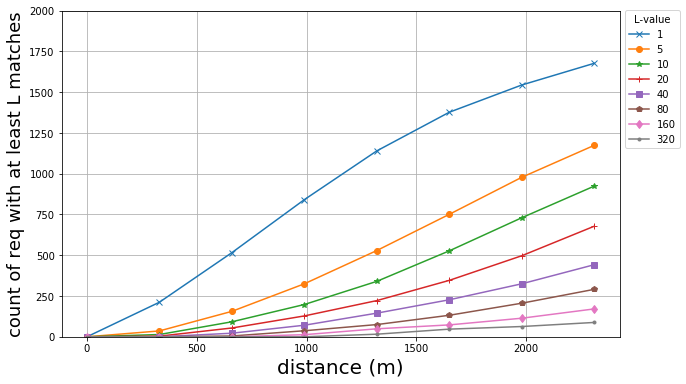

In [574]:
fig = plt.figure(figsize=(10,6))
markers = itertools.cycle(('x', 'o', '*', '+','s','p','d', '.')) 
for l in L_list:
    at_least_l_matches = [(i,j,len([t for t in k if t>=l])) for (i,j,k) in match_counts_per_threshold_cp]
    idx,thresh,ncount = zip(*at_least_l_matches)
    plt.plot(thresh,ncount,label=l,marker=next(markers),markevery=1)

plt.gca().set_ylim((0,2000))
plt.gca().set_xlabel("distance (m)",size=20)
plt.gca().set_ylabel("count of req with at least L matches",size=18)
plt.legend(loc=0,bbox_to_anchor=(1, 1.017),title="L-value")
# plt.title("Number of at least L matches per distance threshold (in meters) - Walking" )
plt.grid()
plt.show()

#### Let's change time threshold as well and see what happens

In [580]:
match_counts_per_threshold_cp_timed = []
distance_threshold = 1800
for t in tqdm_notebook([60,300,600,900,1200,1500,1800]):
    match_counts = []
    for req in reqDF.itertuples():
        potential_matches = ongoingDF
        
        OO_time_mask = ( (potential_matches.time_begin  <= req.time_begin) & (( req.time_begin - potential_matches.time_begin)<=t) )

        potential_matches = potential_matches[OO_time_mask]

        DD_time_mask = ( (req.time_end <= potential_matches.time_end) & (( potential_matches.time_end - req.time_end )<=t) )

        potential_matches = potential_matches[DD_time_mask]
        
        
        OO_distance = np.sqrt( (potential_matches.x_begin - req.x_begin) ** 2 + (potential_matches.y_begin - req.y_begin)**2 )
        
        potential_matches = potential_matches[(OO_distance <= distance_threshold)] 
        
        DD_distance = np.sqrt( (potential_matches.x_end - req.x_end) ** 2 + (potential_matches.y_end - req.y_end)**2 )

        potential_matches = potential_matches[(DD_distance <= distance_threshold)]

        
        match_counts.append(len(potential_matches))
    
    match_counts_per_threshold_cp_timed.append((t,match_counts))

A Jupyter Widget

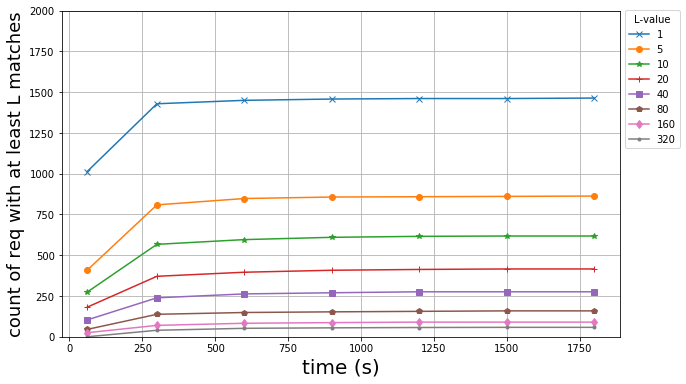

In [581]:
for l in [1,5,10,20,40,80,160,320]:
    at_least_l_matches = [(i,len([t for t in k if t>=l])) for (i,k) in match_counts_per_threshold_cp_timed]
    thresh,ncount = zip(*at_least_l_matches)
    plt.plot(thresh,ncount,label=l,marker=next(markers))
    
fig = plt.gcf()
fig.set_size_inches((10,6))
plt.gca().set_ylim((0,2000))

plt.legend(loc=0,bbox_to_anchor=(1, 1.017),title="L-value")
plt.gca().set_xlabel("time (s)",size=20)
plt.gca().set_ylabel("count of req with at least L matches",size=18)
# plt.title("Number of more than L matches per time threshold (in second)" )
plt.grid()
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### TODO: USE ZIP WITH COLUMNS INSTEAD OF ITERROWS

In [21]:
results = []
for req in tqdm_notebook(reqDF.itertuples(name=None), total=len(reqDF)):
    #Let's filter out far locations
    OO_distance = np.sqrt( (ongoingDF.x_begin - req[2]) ** 2 + (ongoingDF.y_begin - req[3])**2 )
    
    #DD_distance = np.sqrt( (potential_rides.x_end - req[6])**2 + (potential_rides.y_end - req[7])**2 )
    
#     DO_distance = np.sqrt( (ongoingDF.x_end - req[2])**2 + (ongoingDF.y_end - req[3])**2 )
    
    #selecting those trips who are close to us in start point and the request comes at most 10 minutes after their start
    potential_rides1 = ongoingDF[(OO_distance <= distance_threshold) & ((req[1]- ongoingDF.time_begin)<=time_threshold )]
#     print(len(potential_rides1))
#     potential_rides1["DO"] = False
    
    #selecting those that finish near to our start point within 10 minutes
#     potential_rides2 = ongoingDF[(DO_distance < distance_threshold) & ( (req[5] - ongoingDF.time_end)<=time_threshold )]
#     print(len(potential_rides2))
#     potential_rides2["DO"] = True
    
    
#     potential_rides = pd.concat([potential_rides1,potential_rides2])
    potential_rides = potential_rides1
    
    trip_sim_func = get_trip_func(req)

    if potential_rides.empty:
        results.append((req,[]))
    else:
        potential_rides["similarity"] = potential_rides.apply(lambda t : get_trip_similarity_from_tuple(req,t),axis=1)

        top_matches = potential_rides.sort_values(by="similarity",ascending=False)

        results.append( (req, top_matches[:5]) )

A Jupyter Widget

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We don't do real time merging at the moment. But need to measure something arright?.
We start with the amount of time served by this scheme. Also number of matches and average occupancy of each ride?

#### Define measurement scheme: ?

In [22]:
no_match = 0
for req,matches in results:
    print(req)
    print(matches)
    np.sqrt( (ongoingDF.x_end - req[2])**2 + (ongoingDF.y_end - req[3])**2 )
    break

('133877', 29333, 17091.119999999999, 17152.959999999999, 0.0, 29760, 14859.567986987944, 16166.604184910664, 5.3699999)
         time_begin       x_begin       y_begin  spd_begin  time_end  \
trip_id                                                                
1481540       28800  17642.351189  16871.615009      19.76     29483   
1502148       28800  17518.549241  16929.006294       0.00     28985   
1394429       28939  17089.930076  17161.899620       0.00     29361   
1280810       28800  17582.815596  17268.826811       0.00     28816   
37120         28800  17562.488083  17283.344941       1.77     28846   

                x_end         y_end  spd_end  similarity  
trip_id                                                   
1481540  23293.824262  18868.059645     4.32    0.324305  
1502148  18990.376138  17155.649196    13.73    0.278141  
1394429  17982.354263  13628.576608     4.66    0.267750  
1280810  17529.012466  17299.074692     5.30    0.267220  
37120    17423.03744

In [26]:
ongoingDF[:2]

,time_begin,x_begin,y_begin,spd_begin,time_end,x_end,y_end,spd_end
trip_id,,,,,,,,
1509505,29947,11801.55,20658.49,0.0,30304,10247.316951,18694.250121,0.00
1531688,31633,17177.04,3300.27,0.0,32351,23973.969132,3117.020024,13.51


In [29]:
get_trip_similarity(notsampledf[:1],sampledf[:1])

trip_id
1000027   NaN
1509505   NaN
Name: time_begin, dtype: float64

In [30]:
def sim_t1(t1):
    return get_trip_similarity(t1,notsampledf[:1])

In [31]:
res = sampledf.apply(sim_t1,axis=1)

In [32]:
first20 = res.sort_values(res.columns[0],ascending=False)[:20]

In [26]:
notsampledf = ODdf[~ ODdf.index.isin(sampledf.index)]

In [27]:
notsampledf[:1]

,time_begin,x_begin,y_begin,spd_begin,time_end,x_end,y_end,spd_end
trip_id,,,,,,,,
1000027,30448,23406.07,15024.01,0.0,30884,17856.285323,16227.2783,13.63


In [55]:
first20

trip_id,1000027
trip_id,
1022500,0.002771
1320804,0.002667
1043860,0.002029
1117289,0.001632
1056433,0.001105
1226020,0.000774
1363165,0.000669
1007151,0.000594
1371278,0.000558


In [33]:
import time
from IPython.display import clear_output

In [54]:
for i in range(1):
    clear_output(wait=True)
    for index, row in ODdf[ODdf.index.isin(first20.index[:i])].iterrows():
        plt.plot(x=[row.x_begin,row.x_end],y=[row.y_begin,row.y_end])
#     plt.xlim((10000,17000))
#     plt.ylim((6000,15000))
    plt.show()
    time.sleep(1)

In [40]:
t1 = ODdf[ODdf.index=="1201568"]

In [41]:
t2 = ODdf[ODdf.index=="1000032"]

In [42]:
t3 = ODdf[ODdf.index=="1444804"]

In [43]:
t4 = ODdf[ODdf.index=="1311364"]

In [49]:
t1df = pd.DataFrame({"x":[t1.x_begin[0],t1.x_end[0]],"y":[t1.y_begin[0],t1.y_end[0]]})
t2df = pd.DataFrame({"x":[t2.x_begin[0],t2.x_end[0]],"y":[t2.y_begin[0],t2.y_end[0]]})
t3df = pd.DataFrame({"x":[t3.x_begin[0],t3.x_end[0]],"y":[t3.y_begin[0],t3.y_end[0]]})
t4df = pd.DataFrame({"x":[t4.x_begin[0],t4.x_end[0]],"y":[t4.y_begin[0],t4.y_end[0]]})
plt.scatter(x=t1df.x,y=t1df.y)
plt.scatter(x=t2df.x,y=t2df.y)
plt.scatter(x=t3df.x,y=t3df.y)
plt.scatter(x=t4df.x,y=t4df.y)

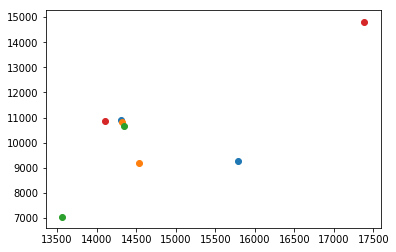

In [50]:
plt.show()